In [1]:
library(readxl)

prb <- read_excel('../data/prb_10-9-2020.xlsx', sheet = 'K-PRB')

Warning message:
"Expecting numeric in D1059 / R1059C4: got 'na'"
New names:
• `Rb` -> `Rb...38`
• `Sr` -> `Sr...40`
• `Th` -> `Th...42`
• `U` -> `U...43`
• `Hf` -> `Hf...45`
• `Pb` -> `Pb...59`
• `Nd` -> `Nd...65`
• `Sm` -> `Sm...66`
• `Lu` -> `Lu...76`
• `Rb` -> `Rb...79`
• `Sr` -> `Sr...80`
• `Sm` -> `Sm...87`
• `Nd` -> `Nd...88`
• `Lu` -> `Lu...94`
• `Hf` -> `Hf...95`
• `U` -> `U...100`
• `Th` -> `Th...101`
• `Pb` -> `Pb...102`


In [2]:
library(tidyverse)

primaries <- select(prb,
    # Major Elements
    "SiO2",
    "TiO2", 
    "Al2O3", 
    "FeO" = "FeO(tot)*", 
    "CaO", 
    "MgO", 
    "K2O", 
    "Na2O",
)

# Coerce fields with values like "> 0.10" to numeric "0.10"
numerical_data <- mutate_at(primaries, vars(-group_cols()), ~ as.numeric(stringr::str_replace_all(., "<", "")))

# numerical_data <- primaries %>% select_if(is.numeric) # Filter out non-numerical fields

# Filter out data with missing values
data <- numerical_data[complete.cases(numerical_data), ]
sprintf('Number of samples: %s', nrow(data))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "Number of samples: 532"

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.92 loaded

Loading required package: cluster



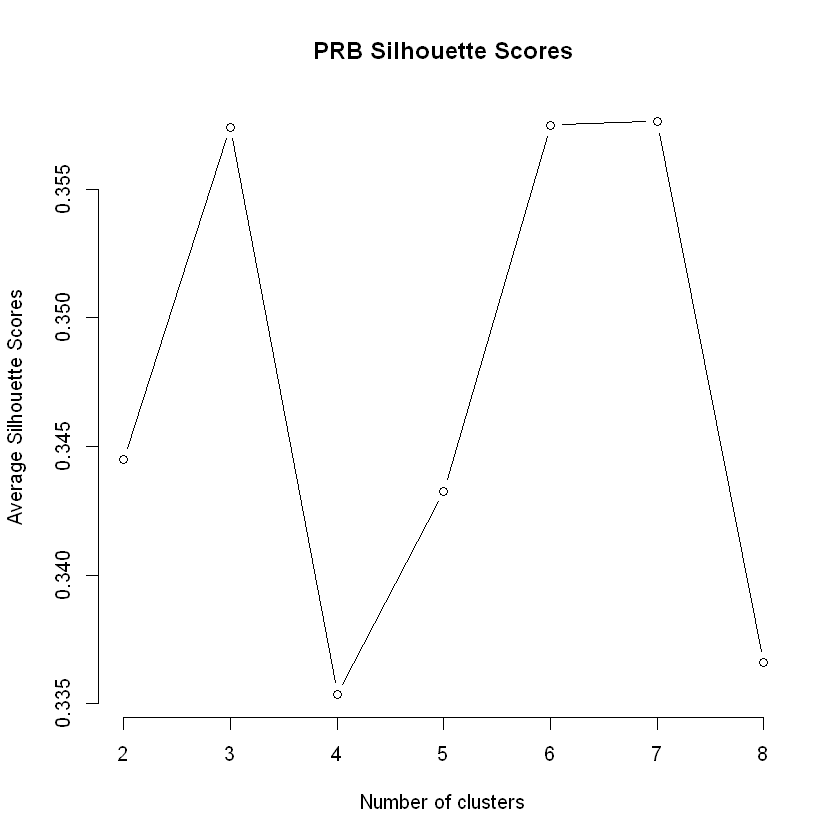

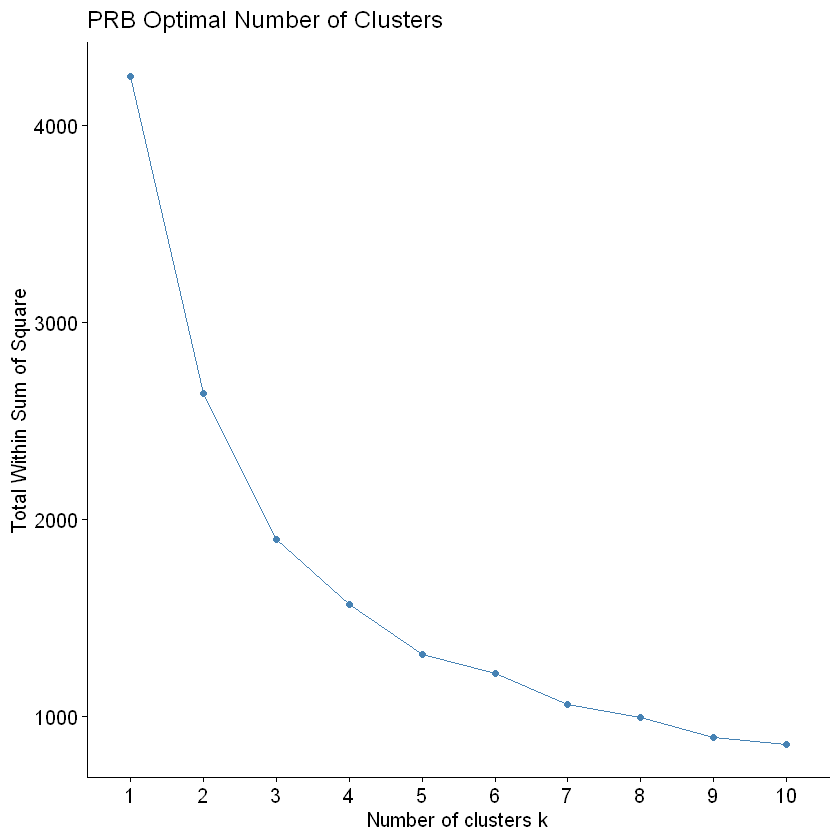

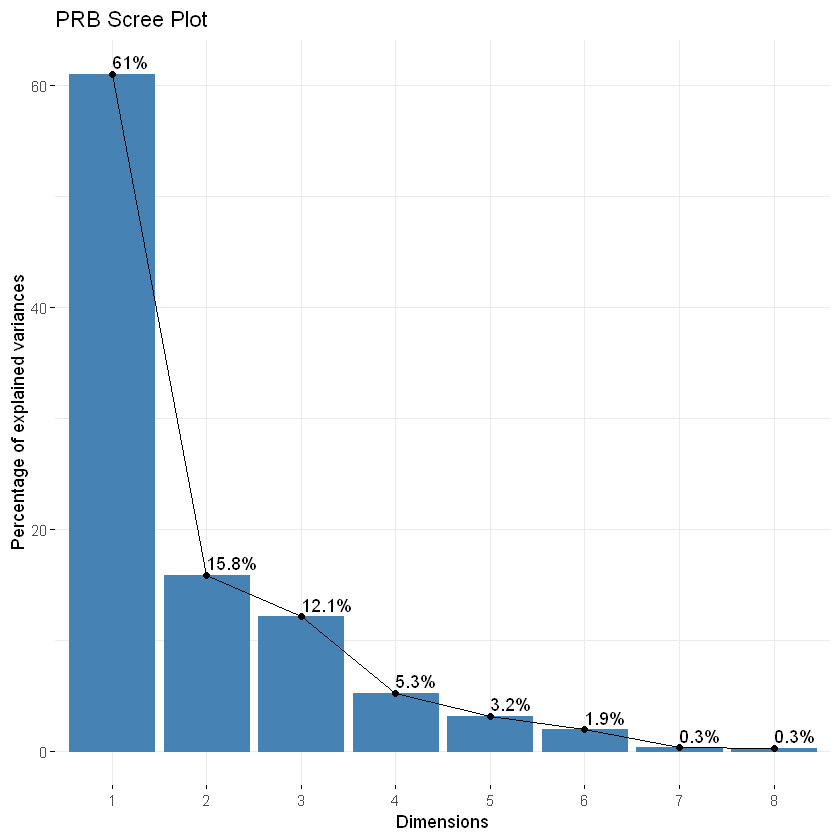

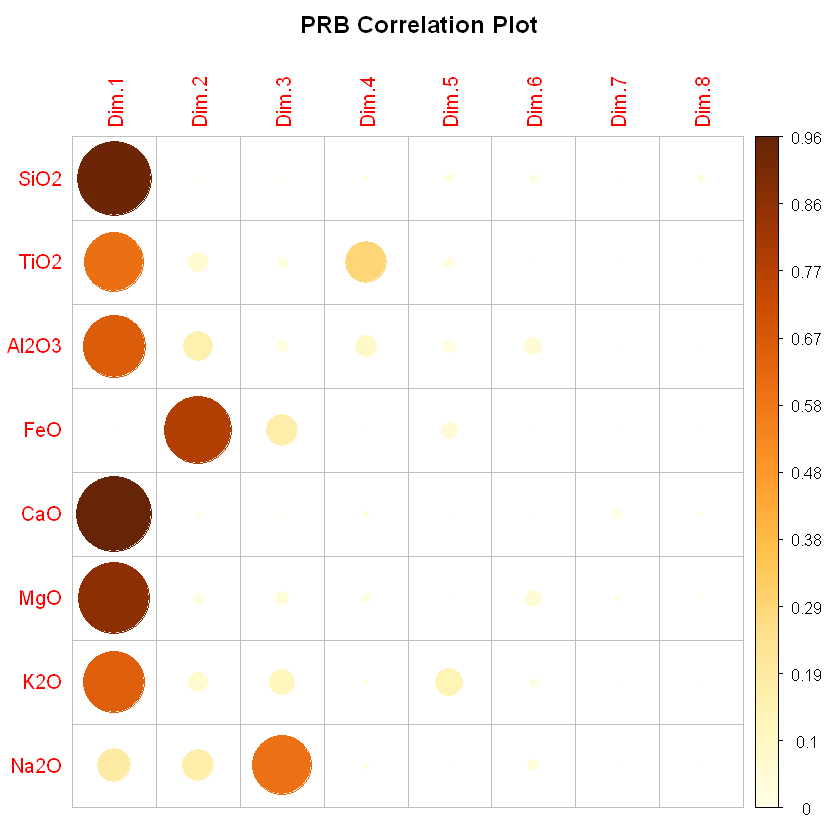

In [3]:
library(factoextra)
library(corrplot)
require(cluster)
set.seed(123)


pca <- prcomp(data, scale = TRUE, center = TRUE)
var <- get_pca_var(pca)
ind <- get_pca_ind(pca)

silhouette_score <- function(k){
  km <- kmeans(ind$coord, centers = k, nstart=25)
  ss <- silhouette(km$cluster, dist(ind$coord))
  mean(ss[, 3])
}
k <- 2:8
avg_sil <- sapply(k, silhouette_score)

plot(k, type='b', avg_sil, xlab='Number of clusters', ylab='Average Silhouette Scores', frame=FALSE, main='PRB Silhouette Scores')
fviz_nbclust(ind$coord, kmeans, method="wss", print.summary=TRUE) + ggtitle("PRB Optimal Number of Clusters")

fviz_eig(pca, addlabels = TRUE, main='PRB Scree Plot')
corrplot(var$cos2, is.corr=FALSE, title='PRB Correlation Plot', mar=c(0, 0, 2, 0))

[1] "RMSE: 1.88947682598734"

cluster,SiO2,TiO2,Al2O3,FeO,CaO,MgO,K2O,Na2O
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50.64032,0.9246774,18.62097,7.937776,10.685484,6.1283871,0.4709677,2.280323
2,64.06233,0.7633074,16.60144,11.122879,4.915914,2.0217510,2.3129183,3.564397
3,72.07189,0.3298566,14.64520,9.328620,2.126516,0.5885246,3.8297746,3.623934


Standard deviations (1, .., p=8):
[1] 2.2092104 1.1259597 0.9848878 0.6491811 0.5049489 0.3947945 0.1643805
[8] 0.1493555

Rotation (n x k) = (8 x 8):
              PC1         PC2         PC3         PC4         PC5           PC6
SiO2  -0.43934905  0.04275907 -0.05790652  0.12008805 -0.26121439  3.083083e-01
TiO2   0.35122995 -0.22873195  0.14041439  0.83249800  0.27715785 -9.730506e-05
Al2O3  0.36729704 -0.34863885  0.16277422 -0.43656214  0.32607629  5.781900e-01
FeO    0.01383155 -0.78440037 -0.41633908  0.02014938 -0.44231646 -5.997340e-02
CaO    0.44365595  0.06181371 -0.04743433 -0.15653496 -0.08320438 -5.477539e-02
MgO    0.42155293  0.12384471 -0.18824891 -0.19988664 -0.08313605 -5.655092e-01
K2O   -0.36691110 -0.23244459 -0.34780619 -0.12116359  0.73071453 -2.938660e-01
Na2O  -0.19836905 -0.36855316  0.78640966 -0.14964948 -0.07212957 -3.973503e-01
              PC7        PC8
SiO2  -0.16283651  0.7730246
TiO2  -0.07155435  0.1720860
Al2O3 -0.26124496  0.1326031
FeO    0.0372

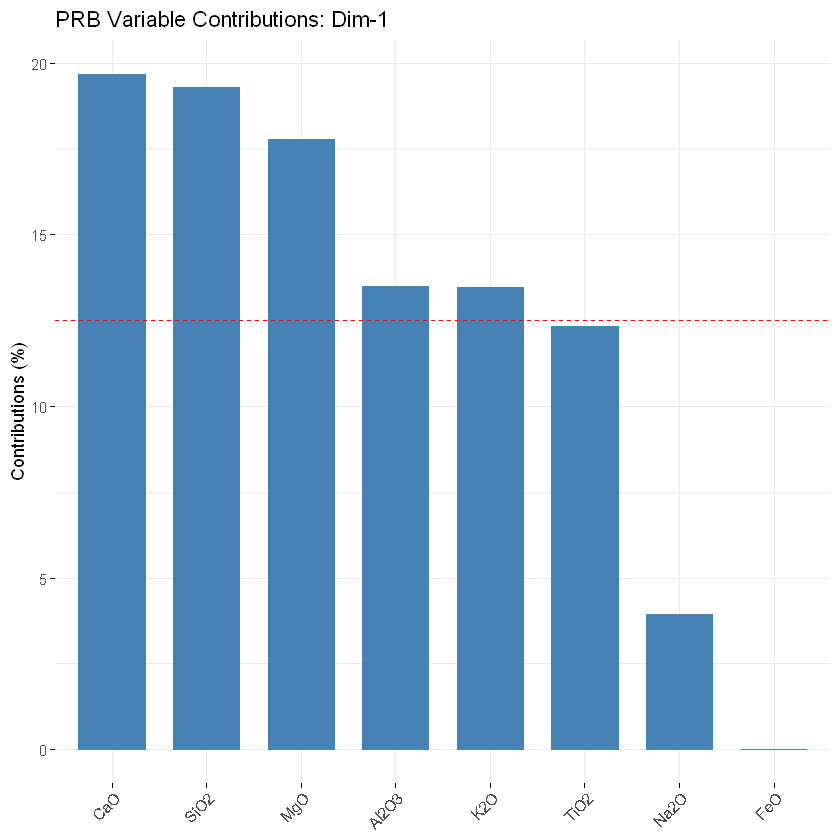

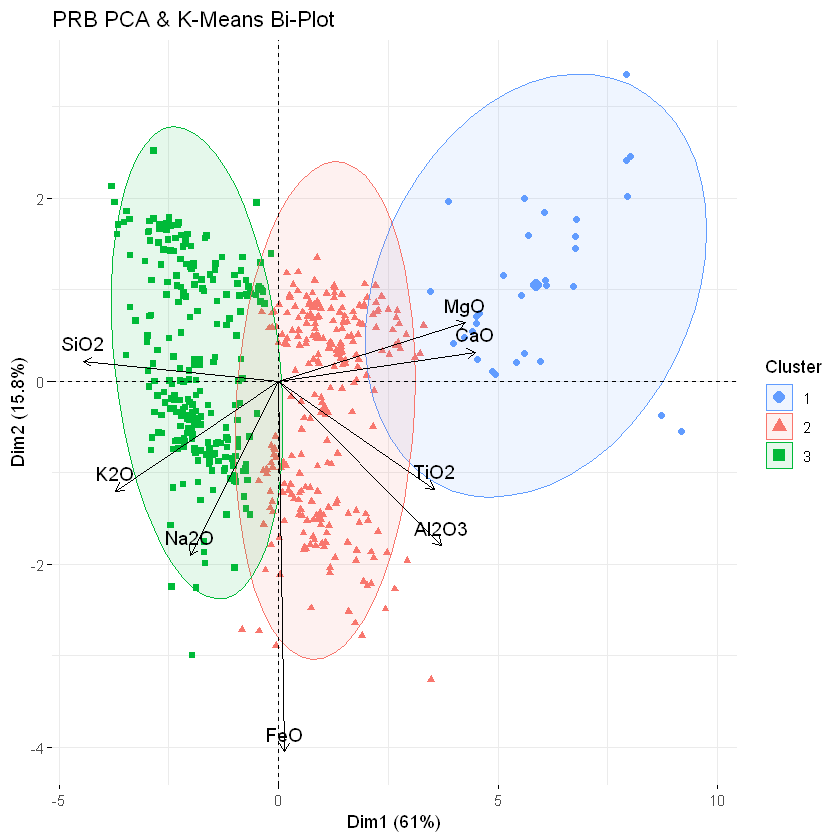

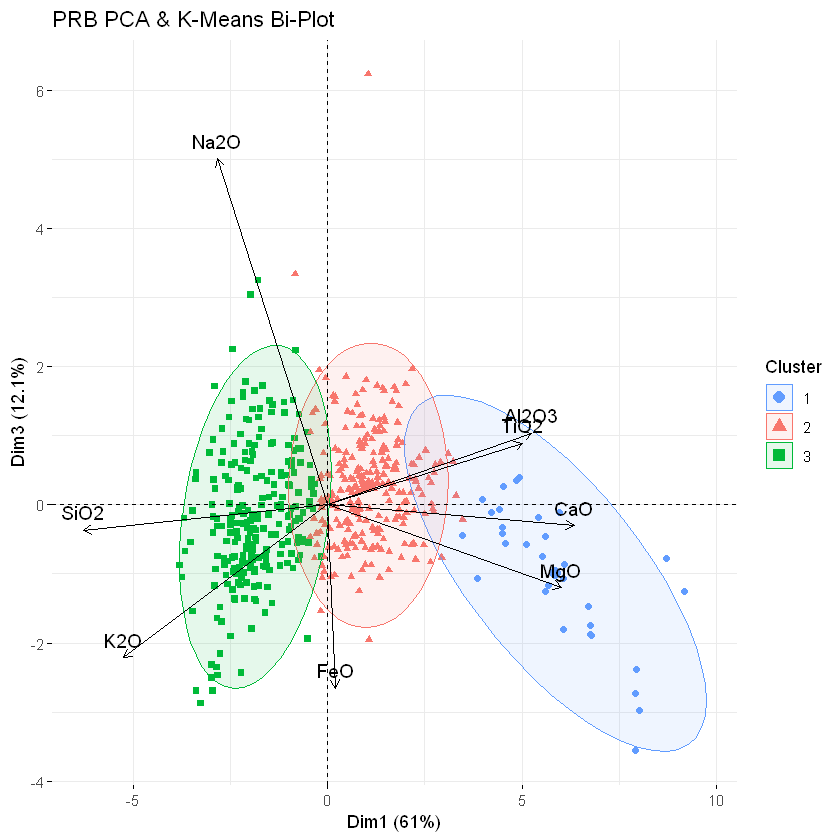

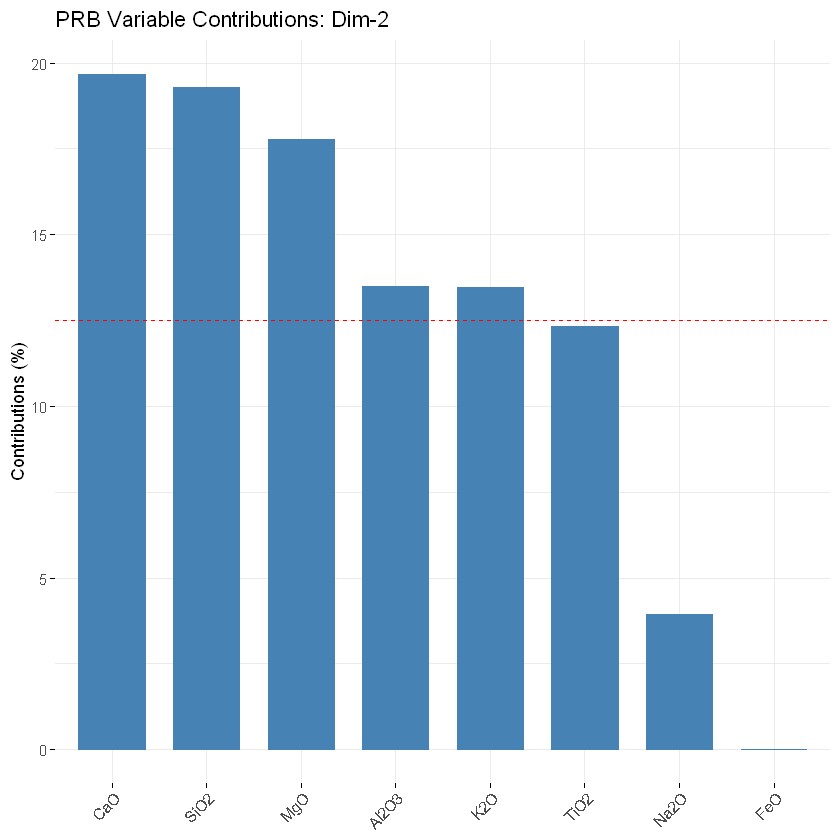

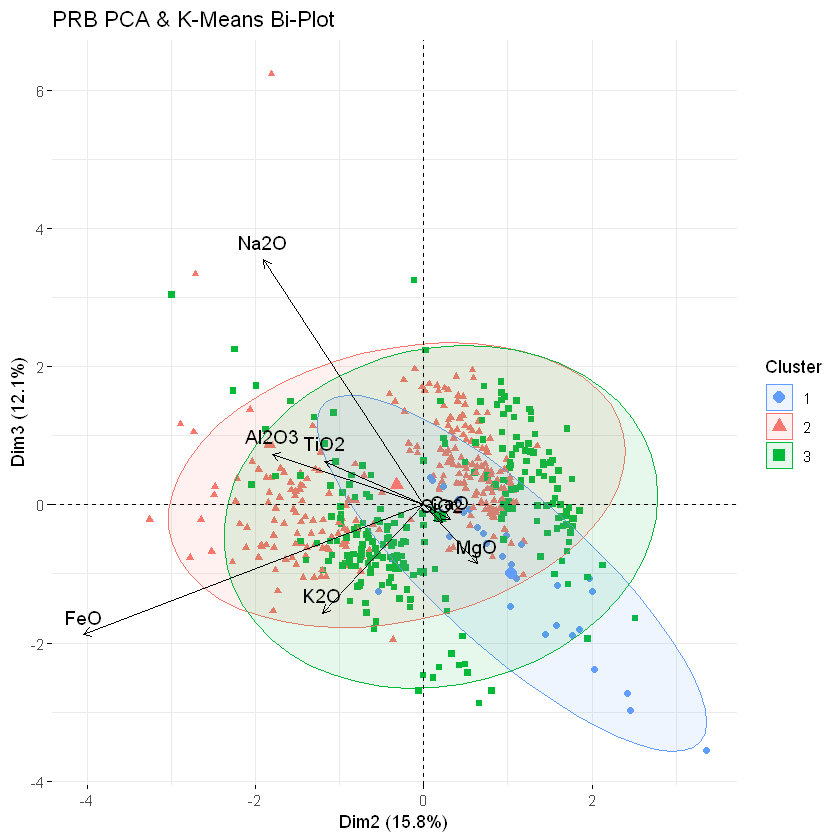

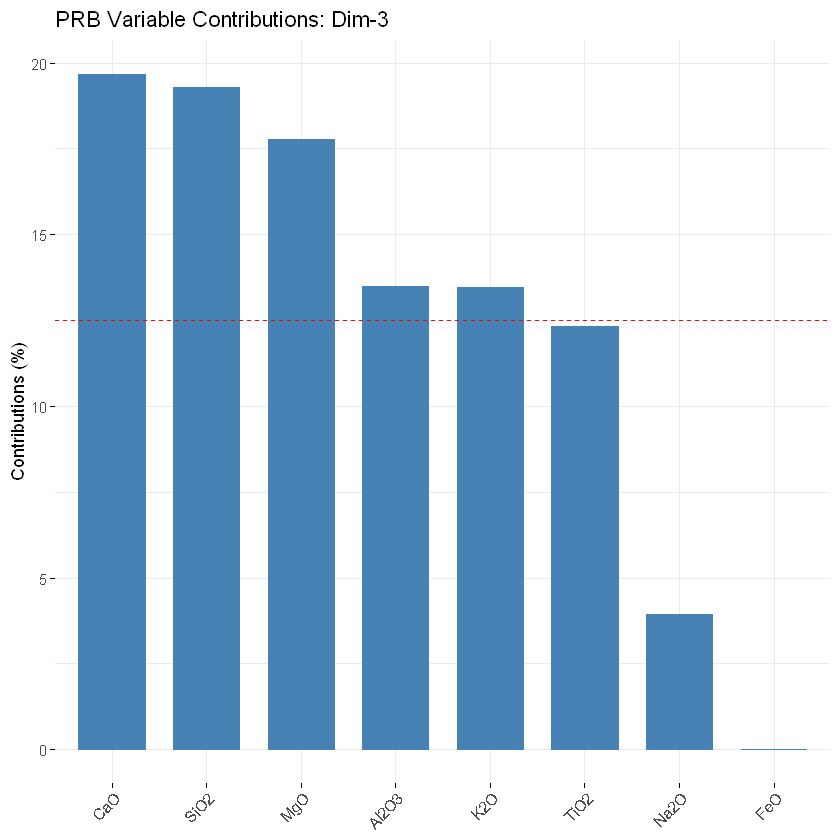

In [16]:
dim <- 3
cluster <- 3

set.seed(123)
km_var <- kmeans(var$coord, centers = cluster, nstart = 25)
km_ind <- kmeans(ind$coord, centers = cluster, nstart = 25)
km_var.grp <- as.factor(km_var$cluster)
km_ind.grp <- as.factor(km_ind$cluster)

# This is just to resort the clusters for easier analysis
relabel <- c(2, 1, 3)
km_ind.grp <- as.factor(relabel[km_ind$cluster])

rmse_ind <- sqrt(sum(km_ind$withinss) / nrow(ind$coord))
sprintf('RMSE: %s', rmse_ind)

clusters <- data.frame(cluster = km_ind$cluster, data)
averages <- aggregate(clusters[,-1], list(cluster = relabel[km_ind$cluster]), mean)
averages

for (i in 1:dim) {

  print(fviz_contrib(pca, choice = "var", axis = i) + ggtitle(sprintf('PRB Variable Contributions: Dim-%s', i)))

  for (k in 1:dim) {
    if (k <= i) next

    print(fviz_pca(pca, 
      col.ind = km_ind.grp,
      col.var = 'black',
      geom.ind = "point",
      addEllipses = TRUE, 
      legend.title = "Cluster",
      axes = c(i, k),
      palette = c('#619cff', '#f8766d', '#00ba38'),
      title = 'PRB PCA & K-Means Bi-Plot'
    ))
  }
}

In [49]:
library(rjson)

# Write pca object to JSON
jsondf <- NULL
# $rotation contains the PCA loadings used to draw the lines
jsondf$rotation <- as.data.frame(pca$rotation)[, 1:dim]
# $x contains the PCA coords used to draw the points (PC1 = x, PC2 = y, etc.)
jsondf$x <- as.data.frame(pca$x)[, 1:dim]
# $cluster contains the cluster assignments as a vector. I.e. the first coordinate pair in $x is equivalent to $cluster[0]
jsondf$clusters <- km_ind.grp
# $features contains the names of the features used in the PCA
jsondf$features <- names(data)

lineCoords <- NULL
for (i in 1:nrow(pca$rotation)) {
  lineCoords <- rbind(lineCoords,
                rbind(c(0, 0, 0),
                    pca$rotation[i, 1:dim]
                )
            )
}

# $lines contains the coordinates of the lines used to draw the loadings
jsondf$lines <- as.data.frame(lineCoords)

write(toJSON(jsondf), file='../json/prb.json')

In [27]:
options(rgl.useNULL = TRUE)
library(rgl)

scores <- as.data.frame(pca$x)
scores[, 1:3]

plot3d(scores[, 1:3], col = km_ind.grp, main = "PCA Scores", size=5)
text3d(pca$rotation[, 1:3], texts = colnames(data), cex = 0.8, col = "red")

coords <- NULL
for (i in 1:nrow(pca$rotation)) {
  coords <- rbind(coords,
                rbind(c(0, 0, 0),
                    pca$rotation[i, 1:3]
                )
            )
}

lines3d(coords, col='red', lwd=1)

widget <- rglwidget(width=1000, height=1000)

htmlwidgets::saveWidget(widget,
    file = "../plots/prb_pca.html", 
    libdir = "../plots/lib",
    selfcontained = TRUE
)

PC1,PC2,PC3
<dbl>,<dbl>,<dbl>
0.53140104,-0.5315020,-0.36910067
-0.08618063,-0.7484462,-0.96825345
-0.96305107,-1.0994438,0.27206331
-1.23174269,-0.9791337,-0.28442609
-0.64599824,-0.6057747,-0.53740141
-1.89063958,-0.7787903,-0.33769964
2.16870867,-1.9308079,-0.58618507
-2.31076644,-0.3420635,-0.26897836
0.46189088,-1.2979847,-0.58565742
